## IMPORT LIBRARY

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## DATA LOADING

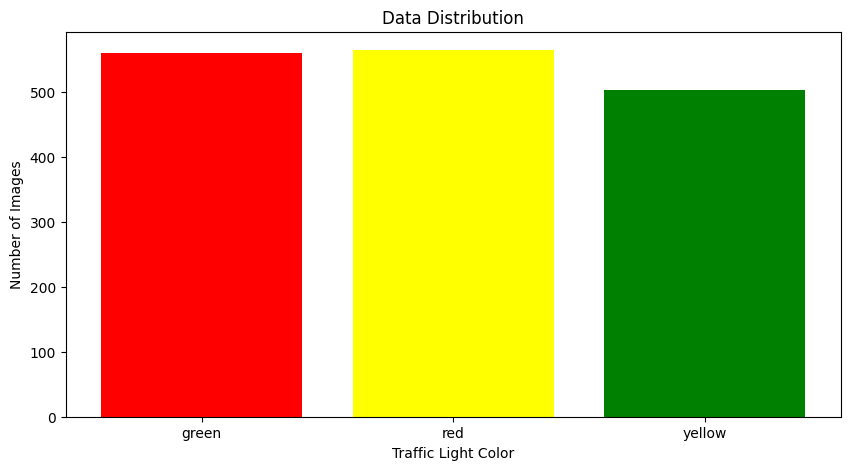

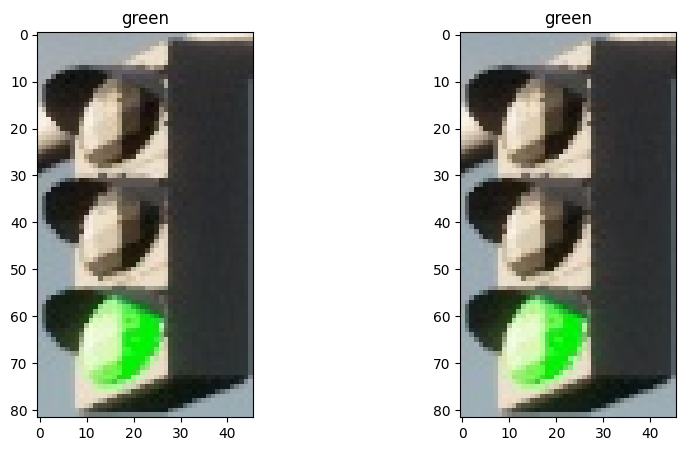

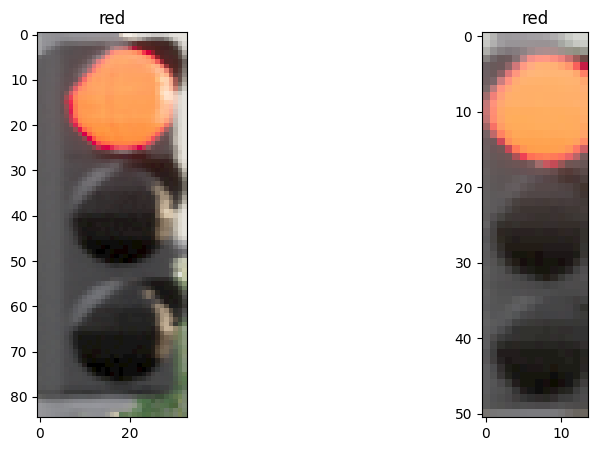

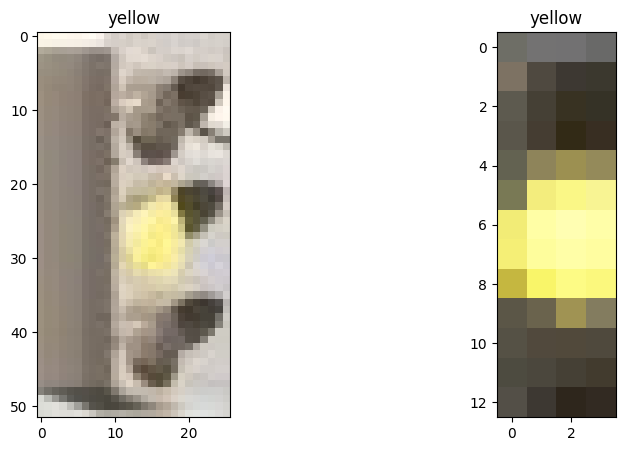

In [2]:


def importImage(path, label):
    images = []
    file_names = os.listdir(path)
    for file_name in file_names:
        file_path = os.path.join(path, file_name)
        image = cv2.imread(file_path)
        images.append((image, label))
    return images

# Load images
imageRed = importImage("traffic_light_data/train/red", "red")
imageYellow = importImage("traffic_light_data/train/yellow", "yellow")
imageGreen = importImage("traffic_light_data/train/green", "green")

# Combine all images
all_images = imageRed + imageYellow + imageGreen

# Display data distribution and sample images
def displayDataDistributionAndSamples(images):
    labels = [image[1] for image in images]
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Display data distribution
    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, counts, color=['red', 'yellow', 'green'])
    plt.xlabel('Traffic Light Color')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution')
    plt.show()

    # Display sample images
    for label in unique_labels:
        sample_images = [image[0] for image in images if image[1] == label][:2]
        plt.figure(figsize=(10, 5))
        for i in range(len(sample_images)):
            plt.subplot(1, 2, i + 1)
            bgr_image = cv2.cvtColor(sample_images[i], cv2.COLOR_BGR2RGB)
            plt.imshow(bgr_image)
            plt.title(label)
        plt.show()

displayDataDistributionAndSamples(all_images)

## DATA AUGMENTATION

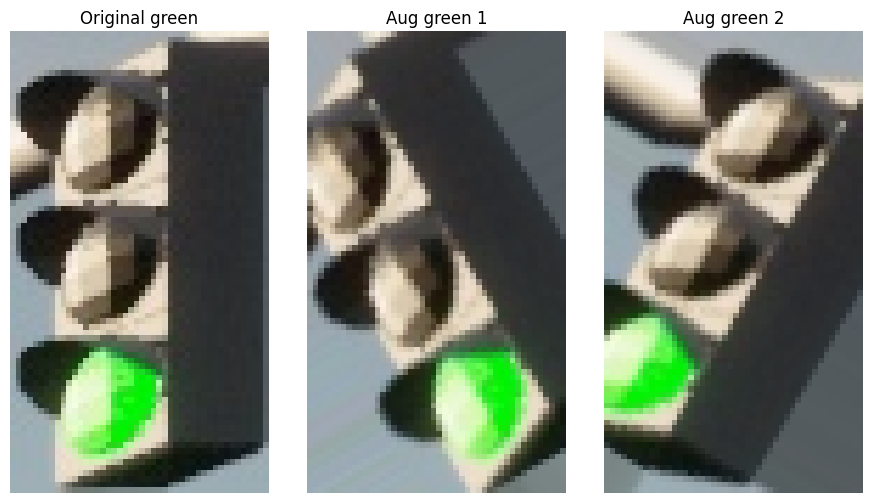

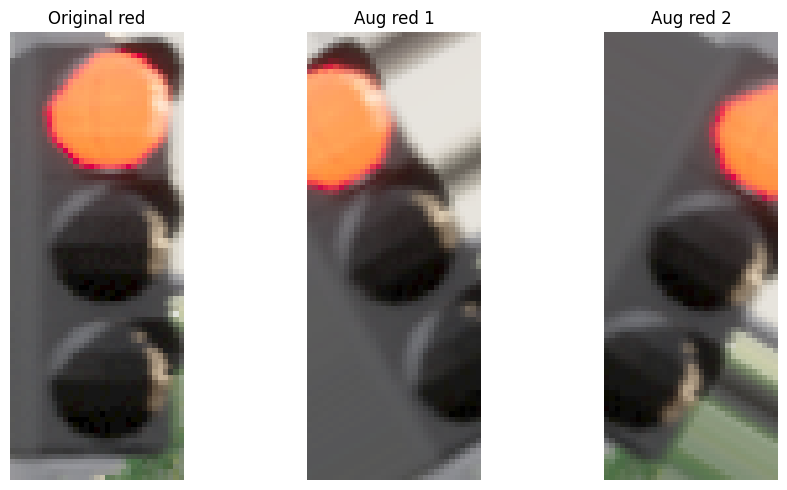

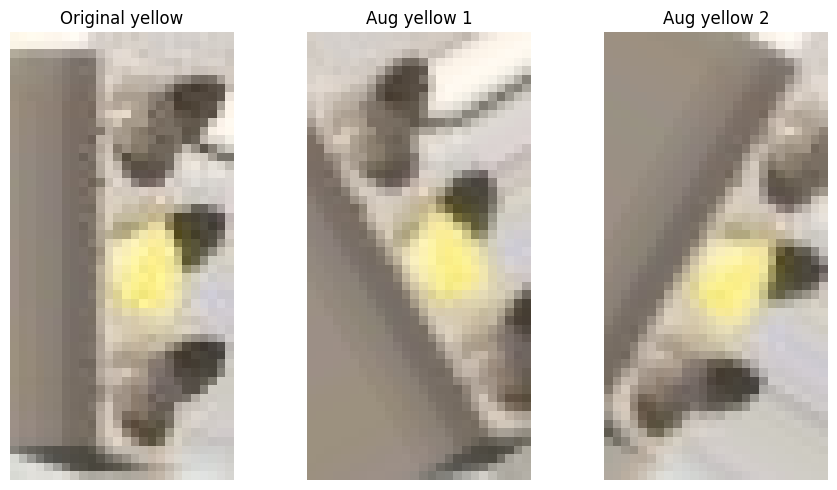

In [3]:
# Function untuk augmentasi gambar
def augment_image(image):
    height, width = image.shape[:2]
    augmented_images = []

    # Function untuk rotasi dan flip
    def rotate_image(image, angle):
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        abs_cos = abs(rot_mat[0,0])
        abs_sin = abs(rot_mat[0,1])
        
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)
        
        rot_mat[0, 2] += bound_w / 2 - image_center[0]
        rot_mat[1, 2] += bound_h / 2 - image_center[1]
        
        rotated_img = cv2.warpAffine(image, rot_mat, (bound_w, bound_h), borderMode=cv2.BORDER_REPLICATE)
        
        crop_x = (bound_w - width) // 2
        crop_y = (bound_h - height) // 2
        cropped_img = rotated_img[crop_y:crop_y + height, crop_x:crop_x + width]
        
        return cropped_img

    # Flipping function
    def flip_image(image, flip_code):
        return cv2.flip(image, flip_code)

    # melakukan augmentasi dan menambahkan ke list
    rotated1 = rotate_image(image, 30)
    augmented_images.append(rotated1)

    rotated2 = rotate_image(image, -30)
    augmented_images.append(rotated2)

    flipped_h = flip_image(image, 1)
    augmented_images.append(flipped_h)

    flipped_v = flip_image(image, 0)
    augmented_images.append(flipped_v)

    rotated_flipped1 = flip_image(rotated1, 1)
    augmented_images.append(rotated_flipped1)

    rotated_flipped2 = flip_image(rotated2, 1)
    augmented_images.append(rotated_flipped2)

    return augmented_images

# Augmentasi data
augmented_images = []
for image, label in all_images:
    augmented_images.extend([(aug_image, label) for aug_image in augment_image(image)])

all_images_augmented = all_images + augmented_images

# Display augmented sample images
def displayAugmentedSamples(images):
    unique_labels = np.unique([label for _, label in images])

    for label in unique_labels:
        sample_images = [image for image, lbl in images if lbl == label][:2]
        augmented_sample_images = [image for image, lbl in augmented_images if lbl == label][:2]
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(sample_images[0], cv2.COLOR_BGR2RGB))
        plt.title(f'Original {label}')
        plt.axis('off')

        for i, aug_img in enumerate(augmented_sample_images):
            plt.subplot(1, 5, i+2)
            plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Aug {label} {i+1}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

displayAugmentedSamples(all_images_augmented)

## PROCESSING

### RESIZE

In [4]:
# Image Processing: Resize
def resizeImage(images):
    images_resize = []
    for image, label in images:
        image_resize = cv2.resize(image, (200, 400))
        images_resize.append((image_resize, label))
    return images_resize

images_resize = resizeImage(all_images_augmented)

### NOISE REMOVAL

In [5]:
# Image Processing: Noise Removal
def noiseRemoval(images):
    images_noise = []
    for image, label in images:
        image_noise = cv2.GaussianBlur(image, (5, 5), 0)
        images_noise.append((image_noise, label))
    return images_noise

images_noise = noiseRemoval(images_resize)

### CONTRAS enhanc

In [6]:
# Image Processing: Contrast Enhancement
def contrastEnhancement(images):
    images_contrast = []
    for image, label in images:
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(image_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab_planes = list(lab_planes)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab_planes = tuple(lab_planes)
        image_lab = cv2.merge(lab_planes)
        image_contrast = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
        images_contrast.append((image_contrast, label))
    return images_contrast

images_contrast = contrastEnhancement(images_noise)

### SATURATION enhanc

In [7]:
# Image Processing: Saturation Enhancement
def saturationEnhancement(images):
    images_saturation = []
    for image, label in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image_hsv)
        saturation_factor = 1.5
        s = np.clip(s.astype(np.float32) * saturation_factor, 0, 255)
        s = np.clip(s, 0, 255).astype(np.uint8)
        image_hsv = cv2.merge([h, s, v])
        image_saturated = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
        images_saturation.append((image_saturated, label))
    return images_saturation

images_saturation = saturationEnhancement(images_contrast)

### SEGMENTATION

In [8]:
# Image Processing: Color Segmentation
def segmentColor(images):
    images_segment = []
    for image, label in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_red = np.array([0, 100, 20])
        upper_red = np.array([179, 255, 255])
        mask_red = cv2.inRange(image_hsv, lower_red, upper_red)
        lower_green = np.array([50, 100, 100])
        upper_green = np.array([70, 255, 255])
        mask_green = cv2.inRange(image_hsv, lower_green, upper_green)
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])
        mask_yellow = cv2.inRange(image_hsv, lower_yellow, upper_yellow)
        mask = mask_red + mask_green + mask_yellow
        image_segment = cv2.bitwise_and(image, image, mask=mask)
        images_segment.append((image_segment, label))
    return images_segment

images_segment = segmentColor(images_saturation)

### EROSI

In [9]:
# Image Processing: Erosion
def erodeImage(images):
    images_erode = []
    kernel = np.ones((20, 20), np.uint8)
    for image, label in images:
        image_erode = cv2.erode(image, kernel, iterations=1)
        images_erode.append((image_erode, label))
    return images_erode

images_erode = erodeImage(images_segment)

## FEATURE EXTRACTION

In [10]:
# Feature Extraction
def extractFeatures(images):
    labels = {"red": 0, "yellow": 1, "green": 2}
    features = []
    target_labels = []

    for image, label in images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[label])

    return np.array(features), np.array(target_labels)

features, target_labels = extractFeatures(images_erode)

## SPLITTING DATA

In [11]:
# Splitting Data
def splitData(features, target_labels):
    X_train, X_test, y_train, y_test = train_test_split(features, target_labels, test_size=0.1, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(features, target_labels)

## NORMALIZATION

In [12]:
# Normalization
def normalizeData(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

X_train, X_test, scaler = normalizeData(X_train, X_test)

## MODELING

### KNN

In [13]:
# K-Nearest Neighbors Model
def trainKNN(X_train, y_train):
    model_knn = KNeighborsClassifier(n_neighbors=3)
    model_knn.fit(X_train, y_train)
    return model_knn


### RANDOM FOREST

In [14]:
# Random Forest Model
def trainRandomForest(X_train, y_train):
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    return model_rf

### SVM

In [15]:
# Support Vector Machine Model
def trainSVM(X_train, y_train):
    model_svm = SVC(kernel='linear', random_state=42)
    model_svm.fit(X_train, y_train)
    return model_svm


In [16]:
# Train all models
model_knn = trainKNN(X_train, y_train)
model_rf = trainRandomForest(X_train, y_train)
model_svm = trainSVM(X_train, y_train)

In [17]:
# Full Image Processing Pipeline
def allProcess(images):
    images_resize = resizeImage(images)
    images_noise = noiseRemoval(images_resize)
    images_contrast = contrastEnhancement(images_noise)
    images_saturation = saturationEnhancement(images_contrast)
    images_segment = segmentColor(images_saturation)
    images_erode = erodeImage(images_segment)
    return images_erode


### TEST

In [18]:
# Prediction
def predictTrafficLightColor(images, model, scaler):
    predict = []
    for image in images:
        avg_color = np.mean(image, axis=(0, 1))
        scaled_color = scaler.transform([avg_color])
        predicted_label = model.predict(scaled_color)
        if predicted_label[0] == 0:
            predict.append("red")
        elif predicted_label[0] == 1:
            predict.append("yellow")
        elif predicted_label[0] == 2:
            predict.append("green")
        else:
            predict.append("unknown")
    return predict


In [19]:
# Random Image Selection for Validation
def randImage():
    folder = ["red", "yellow", "green"]
    real_color = []
    random_images = []
    for i in range(10):  # Reduced number for validation
        folder_rand = random.choice(folder)
        real_color.append(folder_rand)
        path = f"traffic_light_data/val/{folder_rand}/"
        random_image = random.choice(os.listdir(path))
        random_image_path = os.path.join(path, random_image)
        random_image = cv2.imread(random_image_path)
        random_images.append((random_image, folder_rand))
    return random_images, real_color

random_images, real_color = randImage()
random_images_processed = allProcess(random_images)


In [20]:
# Predict using KNN
predicted_color_knn = predictTrafficLightColor([img for img, _ in random_images_processed], model_knn, scaler)
print("KNN - Real:", real_color)
print("KNN - Predicted:", predicted_color_knn)

# Predict using Random Forest
predicted_color_rf = predictTrafficLightColor([img for img, _ in random_images_processed], model_rf, scaler)
print("Random Forest - Real:", real_color)
print("Random Forest - Predicted:", predicted_color_rf)

# Predict using SVM
predicted_color_svm = predictTrafficLightColor([img for img, _ in random_images_processed], model_svm, scaler)
print("SVM - Real:", real_color)
print("SVM - Predicted:", predicted_color_svm)

KNN - Real: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'red']
KNN - Predicted: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'red']
Random Forest - Real: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'red']
Random Forest - Predicted: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'red']
SVM - Real: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'red']
SVM - Predicted: ['red', 'green', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'red']


## EVALUATION

In [21]:
# Evaluation
def calculateAccuracy(real_color, predicted_color):
    correct = 0
    for i in range(len(real_color)):
        if real_color[i] == predicted_color[i]:
            correct += 1
    accuracy = correct / len(real_color)
    return accuracy

accuracy_knn = calculateAccuracy(real_color, predicted_color_knn)
print("KNN Accuracy:", accuracy_knn)

accuracy_rf = calculateAccuracy(real_color, predicted_color_rf)
print("Random Forest Accuracy:", accuracy_rf)

accuracy_svm = calculateAccuracy(real_color, predicted_color_svm)
print("SVM Accuracy:", accuracy_svm)


KNN Accuracy: 0.9
Random Forest Accuracy: 0.9
SVM Accuracy: 0.9
